In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:
def get_vicpop_data(port):
    fission_url = f"http://localhost:{port}/search-vic-population"
    response = requests.get(fission_url,verify=False)
    return response.json()
def get_subcrimecount_data(port):
    fission_url = f"http://localhost:{port}/search-vic-crime-by-offence-count"
    response = requests.get(fission_url,verify=False)
    return response.json()


In [3]:
def process_vic_pop():
    population_data = pd.DataFrame(get_vicpop_data(9030))
    population_cols = [col for col in population_data.columns if 'tpop_' in col and int(col.split('_')[1]) in range(2019, 2024)]
    population_sums = []
    for col in population_cols:
        year = int(col.split('_')[1])
        pop_sum = population_data[col].sum()
        population_sums.append((year, pop_sum))
    population_sums.sort(key=lambda x: x[0])
    return population_sums

In [4]:
def process_vic_subcrime():
    crime_count = pd.DataFrame(get_subcrimecount_data(9030))
    crime_count['Sum of Offence Count' ] = crime_count['Sum of Offence Count' ].astype(str)
    crime_count['Sum of Offence Count' ] = crime_count['Sum of Offence Count' ].str.replace(',', '')
    crime_count['Sum of Offence Count' ] = crime_count['Sum of Offence Count' ].astype(int)
    return crime_count

In [5]:
def combine_vic_pop_crime():
    population_sums = process_vic_pop()    
    crime_count = process_vic_subcrime()
    population_df = pd.DataFrame(population_sums, columns=['year', 'population'])
    merged_df = pd.merge(crime_count, population_df, left_on='filters', right_on='year', how='left')
    merged_df = merged_df.drop(['filters','year'], axis=1)
    return merged_df

In [ ]:
def get_user_input_cdivision():
    input_division = input("Enter Crime Subdivision (A, B, C, D, or E): ")
    if input_division.upper() == "A":
        offence_division = "A Crimes against the person"
    elif input_division.upper() == "B":
        offence_division = "B Property and deception offences"
    elif input_division.upper() == "C":
        offence_division = "C Drug offences"
    elif input_division.upper() == "D":
        offence_division = "D Public order and security offences"
    elif input_division.upper() == "E":
        offence_division = "E Justice procedures offences"
    else:
        offence_division = "Unknown division"
    return offence_division

In [6]:
def plot_offence_vs_population():
    merged_df = combine_vic_pop_crime()
    RANDOM_STATE = 42
    FIG_SIZE = (12, 8)
    N_ESTIMATORS = 100
    
    offence_division = get_user_input_cdivision()
        
    
    # Filter the DataFrame for the specific 'Offence Division: Descending'
    filtered_df = merged_df[merged_df['Offence Division: Descending'] == offence_division]

    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        print(f"No data found for offence division: {offence_division}")
        return

    # Extract the data for the regression models
    X = filtered_df[['population']]
    y = filtered_df['Sum of Offence Count']

    # Linear Regression model
    linear_model = LinearRegression()
    linear_model.fit(X, y)

    # Polynomial Regression model (degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)

    # Random Forest Regression model
    rf_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    rf_model.fit(X, y)

    # Generate predictions
    X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred_linear = linear_model.predict(X_pred)
    y_pred_poly = poly_model.predict(poly.fit_transform(X_pred))
    y_pred_rf = rf_model.predict(X_pred)

    # Use seaborn style for better aesthetics
    sns.set(style='whitegrid')

    # Plotting the line graph
    plt.figure(figsize=FIG_SIZE)
    
    # Scatter plot for actual data
    plt.scatter(filtered_df['population'], filtered_df['Sum of Offence Count'], color='blue', label='Actual Data', s=50)
    
    # Line plots for predictions
    plt.plot(X_pred, y_pred_linear, color='red', linestyle='-', linewidth=2, label='Linear Regression')
    plt.plot(X_pred, y_pred_poly, color='green', linestyle='--', linewidth=2, label='Polynomial Regression (degree 2)')
    plt.plot(X_pred, y_pred_rf, color='purple', linestyle='-.', linewidth=2, label='Random Forest Regression')
    
    # Adding titles and labels
    plt.title(f'Sum of Offence Count vs Population\n({offence_division})', fontsize=16, weight='bold')
    plt.xlabel('Population', fontsize=14)
    plt.ylabel('Sum of Offence Count', fontsize=14)
    
    # Customizing legend
    plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, borderpad=1)
    
    # Enhancing the grid and layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Display the plot
    plt.show()

Enter Crime Subdivision (A, B, C, D, or E): C


C:\Users\EvaNg\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\EvaNg\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


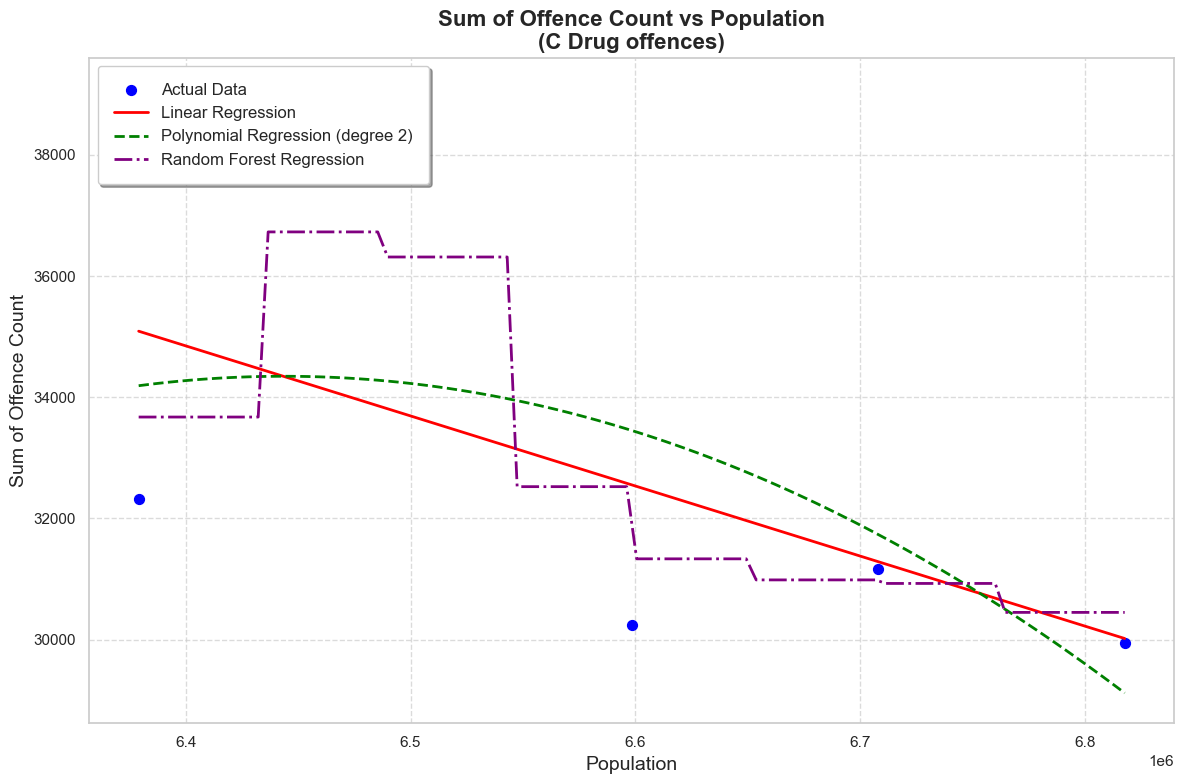

In [13]:
plot_offence_vs_population()